# Classification
Written by W.-H. Shin\
Aug. 2 2025\
Modified from Pat Walter's example.\
In this tutorial, a machine learning model classifies molecules as soluble or not using a decision tree.\
mw, logp, num_arom_rings, hbd, hba are calculated and used as input features.

## Installing softwares and modules

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install seaborn pandas numpy rdkit PyTDC scikit-learn

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - numpy
    - pandas
    - pytdc
    - rdkit
    - scikit-learn
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb9d3cd8_2          18 KB  conda-forge
    ca-certificates-2025.7.14  |       hbd8a1cb_0         152 KB  conda-forge
    cairo-1.18.4               |       h3394656_0         955 KB  conda-forge
    certifi-2025.7.14          |     pyhd8

In [1]:
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm.auto import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, RocCurveDisplay, ConfusionMatrixDisplay # model stats
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

tqdm is employed to visualize progress

In [2]:
#@title Define functions to calculate descriptors using RDKit

def calc_descriptors(mol):
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

The input data used here might have salts and other functionality that cannot be treated properly.\
The function 'statndarize' defined below will solve the problem.\
The original code can be found at https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/

In [3]:
def standardize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

    return taut_uncharged_parent_clean_mol

## Reading data
Reference: https://pubs.acs.org/doi/10.1021/ci034243x

In [4]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()

Downloading...
100%|██████████| 853k/853k [00:00<00:00, 2.77MiB/s]
Loading...
Done!


The data has three fields


- Drug ID: name of the molecule
- Drug: SMILES string of the molecule
- Y: logS (solubility)

In [5]:
sol_df

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


Change the names to be more suitable and re-order columns.

In [6]:
sol_df.columns = ["Molecule Name", "SMILES", "LogS"]
sol_df = sol_df[['SMILES', 'Molecule Name', 'LogS']]
sol_df

,SMILES,Molecule Name,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065
...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000


## Standardzing molecules and set a threshold for determining solubility

In [7]:
tqdm.pandas()
block = BlockLogs() # To remove long logs
sol_df["Mol"] = sol_df["SMILES"].progress_apply(standardize)
del block

  0%|          | 0/9982 [00:00<?, ?it/s]

A new column 'isSol' is added for denoting soluble molecules, with a cutoff of 200 uM.\
A plot will show a distribution.

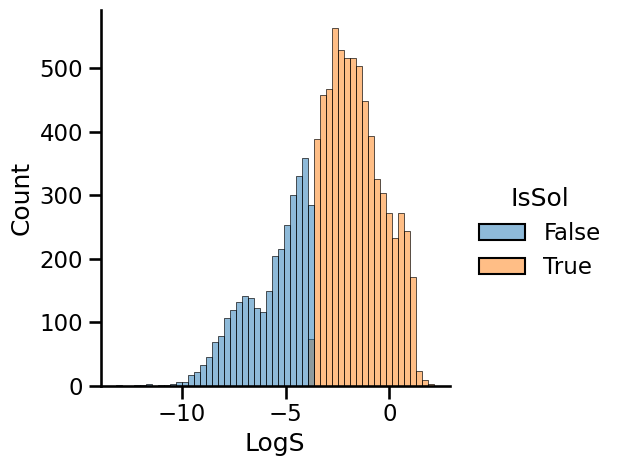

In [8]:
sol_df['IsSol'] = sol_df.LogS > math.log10(200 * 1e-6)
sns.set_context('talk')
sns.displot(x='LogS',hue="IsSol",data=sol_df)

Molecular descriptors will be calculated and added to the table.

In [9]:
sol_df['desc'] = sol_df.Mol.progress_apply(calc_descriptors)

  0%|          | 0/9982 [00:00<?, ?it/s]

Add columns for descriptors and remove 'desc' column from the data.

In [10]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()
sol_df.drop("desc",axis=1,inplace=True)
sol_df

,SMILES,Molecule Name,LogS,Mol,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x7a7842c47ae0>,True,312.606,6.95410,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x7a7842c47a70>,True,169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x7a7842c47840>,True,140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x7a7842c478b0>,False,346.426,5.39400,3.0,2.0,2.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x7a7842c476f0>,False,422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x7a78439aec70>,True,264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x7a78439aece0>,True,444.440,-1.46800,1.0,4.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x7a78439aef80>,True,150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x7a78439af060>,False,454.611,5.09308,2.0,0.0,6.0


## Split data and gererate a model
In order to build a model, we need to split the data into training and test. Train_test_split function of scikit-learn puts 80% to training and 20% to test sets by default.

In [11]:
train, test = train_test_split(sol_df)

Set X and Y values stored in the Pandas dataframe.

In [12]:
train_X = train[desc_cols]
train_Y = train.IsSol
test_X = test[desc_cols]
test_Y = test.IsSol

Generate and train a decision tree classifier.

In [13]:
cls = DecisionTreeClassifier(max_depth=3)
cls.fit(train_X, train_Y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Predict on the test set.

In [14]:
pred = cls.predict(test_X)
auc, mcc = roc_auc_score(test_Y, pred), matthews_corrcoef(test_Y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")

ROC AUC = 0.80
Matthews Correlation Coefficient = 0.61


Plot a confusion matrix and an ROC curve.

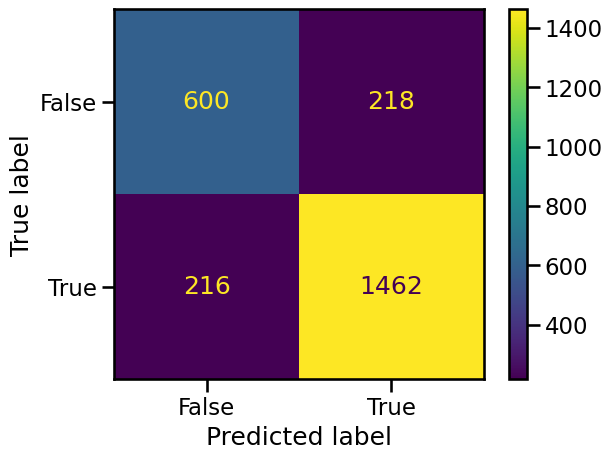

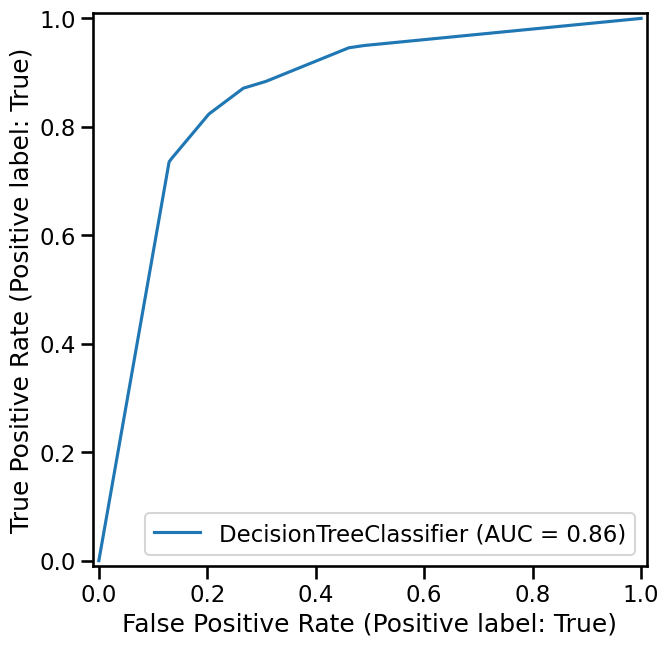

In [15]:
ConfusionMatrixDisplay.from_estimator(cls, test_X, test_Y)

plt.rcParams['figure.figsize'] = [7, 7]
RocCurveDisplay.from_estimator(cls, test_X, test_Y)
plt.tight_layout()

Illustrating the trained tree, a default option of scikit-learn.

[Text(0.5, 0.875, 'LogP <= 3.067\ngini = 0.44\nsamples = 7486\nvalue = [2451, 5035]'),
 Text(0.25, 0.625, 'LogP <= 2.672\ngini = 0.21\nsamples = 5067\nvalue = [604, 4463]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'MW <= 293.293\ngini = 0.165\nsamples = 4564\nvalue = [413, 4151]'),
 Text(0.0625, 0.125, 'gini = 0.124\nsamples = 3930\nvalue = [261, 3669]'),
 Text(0.1875, 0.125, 'gini = 0.365\nsamples = 634\nvalue = [152.0, 482.0]'),
 Text(0.375, 0.375, 'MW <= 278.717\ngini = 0.471\nsamples = 503\nvalue = [191, 312]'),
 Text(0.3125, 0.125, 'gini = 0.435\nsamples = 366\nvalue = [117.0, 249.0]'),
 Text(0.4375, 0.125, 'gini = 0.497\nsamples = 137\nvalue = [74, 63]'),
 Text(0.75, 0.625, 'LogP <= 3.872\ngini = 0.361\nsamples = 2419\nvalue = [1847, 572]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'HBA <= 0.5\ngini = 0.479\nsamples = 801\nvalue = [483, 318]'),
 Text(0.5625, 0.125, 'gini = 0.282\nsamples = 100\nvalue = [83, 17]'),
 Text(0.6875, 0.125, 'gini = 0.49\nsamples = 7

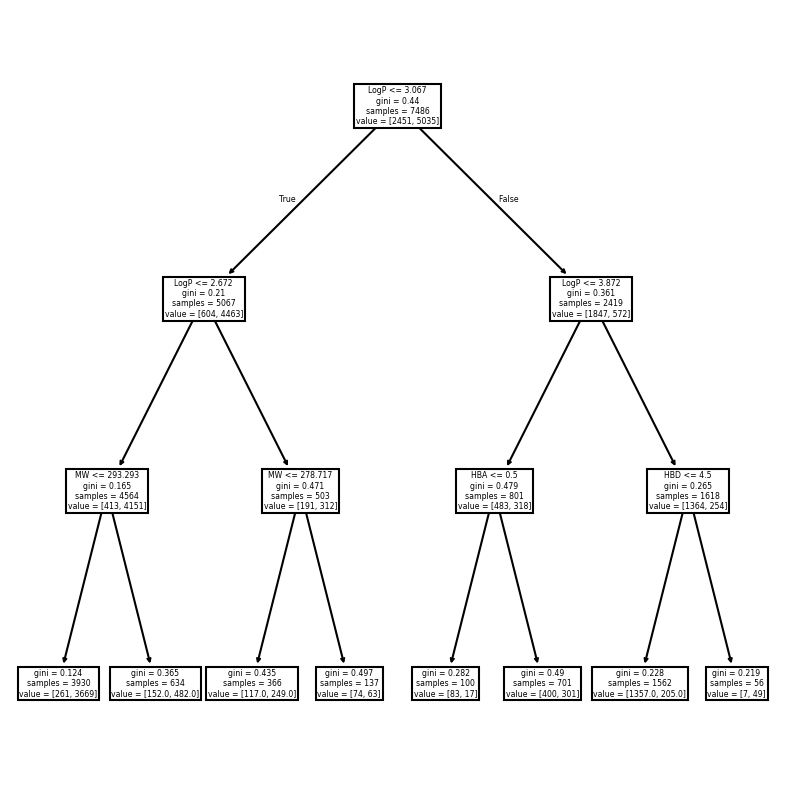

In [16]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

As a final check we're going to see if we can fit a model to incorrect data. If we shuffle the y values, we shouldn't be able to get a good model.

Shuffle the y-variable as a sanity check

In [17]:
sol_df['fake'] = sol_df.IsSol.sample(frac=1)

Split the dataframe into training a test sets.

In [18]:
fake_train, fake_test = train_test_split(sol_df)
fake_train_X = fake_train[desc_cols]
fake_train_Y = fake_train.fake
fake_test_X = fake_test[desc_cols]
fake_test_Y = fake_test.fake

Build a classifer

In [19]:
fake_cls = DecisionTreeClassifier(max_depth=3)
fake_cls.fit(fake_train_X,fake_train_Y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Do prediction: the model does not predict well.

In [20]:
fake_pred = fake_cls.predict(fake_test_X)
roc_auc_score(fake_test_Y,pred)

0.4993558565910451